<a href="https://colab.research.google.com/github/rusini666/AletheiaAI-LIME-SHAP/blob/main/lime_shap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install shap lime pdfplumber transformers peft
!pip install torch  # or 'pip install torch' if you need an updated torch version
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 50.0 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=f15dcb01872510780822b259c1900b123147ba90d827456513754d3738868cf4
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [8]:
import re
import string
import json
from datetime import datetime
import types
import pickle
import os
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'  # only relevant on Apple Silicon with MPS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_fscore_support
)

# SHAP & LIME
import shap
from lime.lime_text import LimeTextExplainer

# For reading PDFs
import pdfplumber

from peft import get_peft_model, LoraConfig, TaskType
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    get_linear_schedule_with_warmup
)

from tqdm import tqdm
import nltk
nltk.download('punkt_tab')
import ssl

# (Optional) If behind a restricted SSL environment:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Initialize SHAP’s JS for interactive plots
shap.initjs()

app_configs = {}


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
class PreprocessDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        texts = dataframe.text.values.tolist()
        texts = [self._preprocess(text) for text in texts]

        self.texts = [
            tokenizer(
                text,
                padding='max_length',
                max_length=150,
                truncation=True,
                return_tensors="pt"
            )
            for text in texts
        ]

        if 'label' in dataframe:
            self.labels = dataframe.label.values.tolist()

    def _preprocess(self, text):
        text = self._remove_amp(text)
        text = self._remove_links(text)
        text = self._remove_hashes(text)
        text = self._remove_mentions(text)
        text = self._remove_multiple_spaces(text)
        text = self._remove_punctuation(text)

        text_tokens = self._tokenize(text)
        text_tokens = self._stopword_filtering(text_tokens)
        text = " ".join(text_tokens)
        return text.strip()

    def _remove_amp(self, text):
        return text.replace("&amp;", " ")

    def _remove_mentions(self, text):
        return re.sub(r'(@.*?)[\s]', ' ', text)

    def _remove_multiple_spaces(self, text):
        return re.sub(r'\s+', ' ', text)

    def _remove_links(self, text):
        return re.sub(r'https?:\/\/[^\s\n\r]+', ' ', text)

    def _remove_hashes(self, text):
        return re.sub(r'#', ' ', text)

    def _tokenize(self, text):
        return nltk.word_tokenize(text, language="english")

    def _stopword_filtering(self, text_tokens):
        stop_words = nltk.corpus.stopwords.words('english')
        return [token for token in text_tokens if token.lower() not in stop_words]

    def _remove_punctuation(self, text):
        return ''.join(ch for ch in text if ch not in string.punctuation)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = -1
        if hasattr(self, 'labels'):
            label = self.labels[idx]
        return text, label


In [10]:
# Example for an OPT-based classifier
class CustomOPTClassifier(nn.Module):
    def __init__(self, pretrained_model):
        super(CustomOPTClassifier, self).__init__()

        self.opt = pretrained_model
        # For large OPT models, the final dimension is the vocab size.
        self.fc1 = nn.Linear(pretrained_model.config.vocab_size, 32)
        self.fc2 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask):
        attention_mask = attention_mask.squeeze(1)
        opt_out = self.opt(
            input_ids=input_ids,
            attention_mask=attention_mask
        ).logits  # (batch_size, seq_length, vocab_size)

        # Take the last token's logits
        opt_out = opt_out[:, -1, :]  # shape: (batch_size, vocab_size)

        x = self.fc1(opt_out)
        x = self.relu(x)
        x = self.fc2(x)
        return x


def str_to_class(s):
    return globals()[s]

def target_device():
    """Use GPU if available, else MPS on Apple Silicon, else CPU."""
    if torch.cuda.is_available():
        device = torch.device("cuda")  # Use GPU
    elif torch.backends.mps.is_available():
        device = torch.device("mps")  # Use MPS on Apple Silicon
    else:
        device = torch.device("cpu")  # Fallback to CPU
    app_configs['device'] = device
    print(f"Using device: {device}")
    return device

def get_pretrained_model():
    """Load tokenizer + base model, applying LoRA if used."""
    tokenizer = AutoTokenizer.from_pretrained(app_configs['base_model'])
    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})

    pretrained_model = AutoModelForCausalLM.from_pretrained(app_configs['base_model'])

    # If you trained with LoRA
    lora_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM,
        r=8,
        lora_alpha=32,
        lora_dropout=0.1,
        target_modules=["q_proj", "v_proj"]
    )
    model_with_lora = get_peft_model(pretrained_model, lora_config)

    return tokenizer, model_with_lora


In [13]:
from collections import Counter
import nltk
import string

nltk.download("punkt")
nltk.download("stopwords")

def build_dynamic_stopwords(all_texts, top_n=50):
    """
    1) For each text in `all_texts`, tokenize & remove standard stopwords and punctuation.
    2) Collect frequency of remaining tokens across the entire corpus.
    3) Return the top_n most frequent tokens as "less meaningful" words.
    """
    from nltk.corpus import stopwords
    english_stop = set(stopwords.words("english"))

    # We’ll gather every token here
    tokens_all = []

    for text in all_texts:
        # Basic cleaning + tokenize
        raw_tokens = nltk.word_tokenize(text, language="english")
        # remove punctuation and standard stopwords
        cleaned_tokens = [
            t.lower() for t in raw_tokens
            if t.lower() not in english_stop
            and t not in string.punctuation
        ]
        tokens_all.extend(cleaned_tokens)

    # Build a frequency list
    freq_counter = Counter(tokens_all)
    # Identify the top_n items
    most_common = freq_counter.most_common(top_n)

    # Return just the tokens (not their counts)
    dynamic_stopwords = set([word for (word, _) in most_common])
    return dynamic_stopwords

def custom_tokenize(text, dynamic_stopwords):
    """
    Remove punctuation, standard stopwords, and
    also words in the 'dynamic_stopwords' set.
    """
    from nltk.corpus import stopwords
    english_stop = set(stopwords.words("english"))

    raw_tokens = nltk.word_tokenize(text, language="english")
    cleaned_tokens = []

    for token in raw_tokens:
        t_lower = token.lower()
        # Remove if it's standard stopword, punctuation, or in dynamic_stopwords
        if (
            t_lower not in english_stop
            and t_lower not in dynamic_stopwords
            and token not in string.punctuation
        ):
            cleaned_tokens.append(token)

    return cleaned_tokens

def clean_text_for_explanation(text, dynamic_stopwords):
    """
    A convenience function that re-joins the tokens
    after removing 'dynamic_stopwords' and standard stopwords.
    """
    tokens = custom_tokenize(text, dynamic_stopwords)
    return " ".join(tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
def predict_proba_for_explanations(texts, model, tokenizer, device):
    """
    Return [p(Human), p(AI)] for each text in 'texts'.
    """
    model.eval()
    probs = []
    for txt in texts:
        inputs = tokenizer(txt, padding="max_length", truncation=True, max_length=150, return_tensors="pt").to(device)
        with torch.no_grad():
            logits = model(inputs["input_ids"], inputs["attention_mask"])
            p_ai = torch.sigmoid(logits).item()
            p_human = 1 - p_ai
        probs.append([p_human, p_ai])
    return np.array(probs)


def shap_explanation(model, tokenizer, device, text_sample, dynamic_stopwords):
    import shap

    # Clean text
    cleaned_text = clean_text_for_explanation(text_sample, dynamic_stopwords)

    # No custom tokenizer param here!
    text_masker = shap.maskers.Text()

    explainer = shap.Explainer(
        lambda T: predict_proba_for_explanations(T, model, tokenizer, device),
        masker=text_masker
    )
    shap_values = explainer([cleaned_text])

    print("\n=== SHAP Interactive Highlight ===")
    shap.plots.text(shap_values[0])

    print("\n=== SHAP Bar Chart ===")
    shap.plots.bar(shap_values[0][:, 1])

    return shap_values[0]

def lime_explanation(model, tokenizer, device, text_sample, dynamic_stopwords):
    """
    LIME with bar chart, ignoring dynamic stopwords for the text.
    """
    cleaned = clean_text_for_explanation(text_sample, dynamic_stopwords)

    def lime_predict(txts):
        return predict_proba_for_explanations(txts, model, tokenizer, device)

    explainer = LimeTextExplainer(class_names=["Human", "AI"])
    exp = explainer.explain_instance(
        cleaned,
        classifier_fn=lime_predict,
        labels=[1],
        num_features=10
    )

    print("\n=== LIME Feature List (AI class) ===")
    print(exp.as_list(label=1))

    print("\n=== LIME Bar Chart ===")
    fig = exp.as_pyplot_figure(label=1)
    fig.suptitle("LIME Explanation (AI class)")
    fig.show()

    return exp

def generate_natural_language_summary(
    text_sample,
    shap_values_for_text,
    lime_exp_for_text,
    top_n=5
):
    """
    A more user-friendly explanation summary (rather than raw numeric lines).
    """

    # Gather SHAP tokens
    token_contribs = []
    for i, token in enumerate(shap_values_for_text.data):
        shap_ai = shap_values_for_text.values[i, 1]
        token_contribs.append((token, shap_ai))
    # Sort by abs value
    token_contribs.sort(key=lambda x: abs(x[1]), reverse=True)

    # top positives => push AI
    top_positive = [t for t in token_contribs if t[1] > 0]
    top_positive.sort(key=lambda x: x[1], reverse=True)
    top_positive = top_positive[:top_n]

    # top negatives => push Human
    top_negative = [t for t in token_contribs if t[1] < 0]
    top_negative.sort(key=lambda x: x[1])  # ascending => more negative
    top_negative = top_negative[:top_n]

    # LIME top features => label=1 => AI
    lime_list = lime_exp_for_text.as_list(label=1)
    lime_list.sort(key=lambda x: abs(x[1]), reverse=True)
    lime_top = lime_list[:top_n]

    lines = []
    lines.append("====================================================")
    lines.append("                    EXPLANATION SUMMARY")
    lines.append("====================================================\n")

    # Summarize top SHAP-positive (pushing AI)
    if top_positive:
        tokens_only = [tok for (tok, _) in top_positive]
        lines.append(
            "Based on SHAP, the words that especially pushed the classification "
            f"toward 'AI-generated' are: {', '.join(tokens_only)}. "
            "These words had the most positive influence on the model's AI probability."
        )
    else:
        lines.append("No words were strongly pushing toward AI according to SHAP.")

    lines.append("")

    # Summarize top SHAP-negative (pushing Human)
    if top_negative:
        tokens_only = [tok for (tok, _) in top_negative]
        lines.append(
            "On the other hand, these words made the model lean more toward 'Human-written': "
            f"{', '.join(tokens_only)}. "
            "Their presence decreased the likelihood of an AI-generated text."
        )
    else:
        lines.append("No words were strongly pushing toward Human according to SHAP.")

    lines.append("")

    # Summarize top LIME tokens
    if lime_top:
        # separate positives & negatives
        lime_pos = [tok for (tok, w) in lime_top if w > 0]
        lime_neg = [tok for (tok, w) in lime_top if w < 0]

        lines.append("From the LIME perspective:")
        if lime_pos:
            lines.append(
                f"- The words {', '.join(lime_pos)} also push the classifier toward 'AI'."
            )
        if lime_neg:
            lines.append(
                f"- The words {', '.join(lime_neg)} push the classifier toward 'Human'."
            )
        lines.append("LIME uses a different method but confirms which words matter.")
    else:
        lines.append("LIME didn't find any strong features pushing the text to AI or Human.")

    lines.append("\nIn summary, these keywords gave the model important cues "
                 "about whether the text was likely AI-generated or human-written.\n")

    return "\n".join(lines)

In [15]:
def classify_and_explain(user_text, model, tokenizer, device, dynamic_stopwords):
    """
    1) Print the dynamic_stopwords discovered from the user's input (for demonstration).
    2) Classify with cleaned text (assuming the model was trained on cleaned text).
    3) Show SHAP & LIME visuals.
    4) Print a more natural-language summary.
    """
    print(f"--- Dynamic Stopwords derived from user's text ---\n{dynamic_stopwords}\n")

    # Clean for classification
    cleaned_text = clean_text_for_explanation(user_text, dynamic_stopwords)

    # Classification
    inputs = tokenizer(
        cleaned_text,
        padding="max_length", max_length=150, truncation=True,
        return_tensors="pt"
    ).to(device)

    model.eval()
    with torch.no_grad():
        logits = model(inputs["input_ids"], inputs["attention_mask"])
        p_ai = torch.sigmoid(logits).item()
    p_human = 1 - p_ai
    label_pred = "AI" if p_ai > 0.5 else "Human"

    print("=== CLASSIFICATION RESULT ===")
    print(f"Predicted label: {label_pred}")
    print(f"Prob(AI)={p_ai:.3f}, Prob(Human)={p_human:.3f}")

    # SHAP
    shap_vals = shap_explanation(model, tokenizer, device, user_text, dynamic_stopwords)
    # LIME
    lime_exp = lime_explanation(model, tokenizer, device, user_text, dynamic_stopwords)

    # Natural-language summary
    explanation_report = generate_natural_language_summary(
        text_sample=user_text,
        shap_values_for_text=shap_vals,
        lime_exp_for_text=lime_exp,
        top_n=5
    )
    print(explanation_report)

Using device: cuda
[WARNING] No checkpoint found at: /content/drive/My Drive/Model/models/202409230028_subtaskA_monolingual_facebook_opt-1.3b.pt. Classification may be random.
Enter or paste your text (then press Enter):
Conspiracy Theories: A Double-Edged Sword Conspiracy theories have fascinated humanity for centuries, weaving tales that blend fact and fiction. These theories, ranging from alien cover-ups to secret government plots, often captivate the imagination and provoke debates about truth, trust, and the human desire for understanding. While they can reveal societal anxieties and foster skepticism, they can also lead to dangerous misinformation and erode public trust in institutions.  The Roots of Conspiracy Theories At their core, conspiracy theories stem from a basic human need to make sense of the world, especially in times of uncertainty or crisis. When events seem inexplicable or overwhelming, the mind seeks patterns and connections to restore a sense of control. This cog

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:30, 90.08s/it]               


=== SHAP Interactive Highlight ===



=== SHAP Bar Chart ===


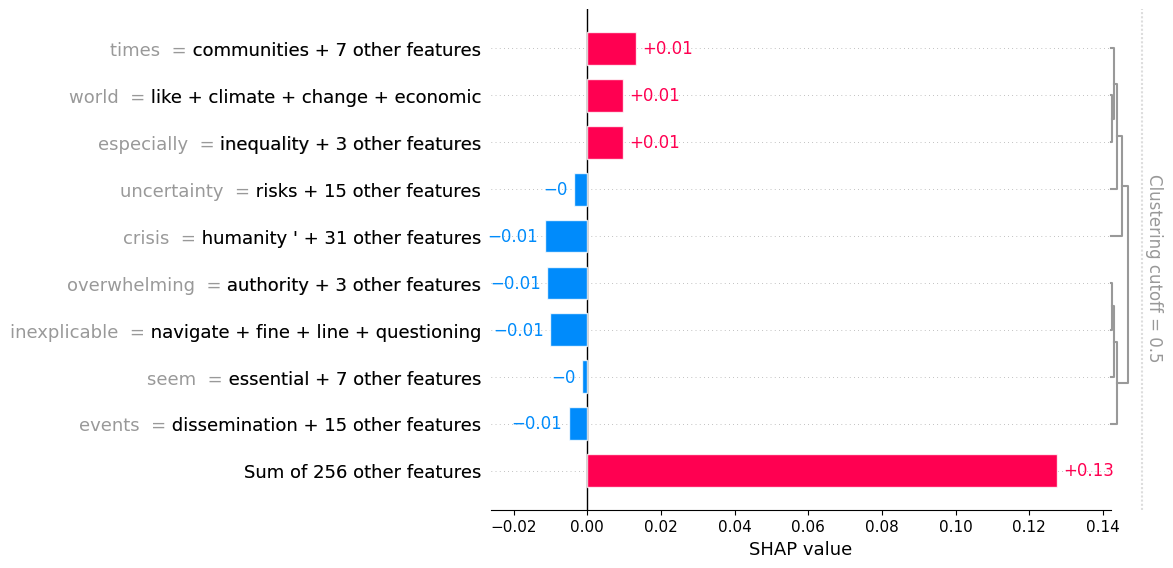


=== LIME Feature List (AI class) ===
[('Social', 0.04797029513497678), ('video', 0.037805228199421934), ('Appeal', 0.022499751922581912), ('Double', 0.020632475091536352), ('Spread', 0.018455521640434385), ('Syphilis', 0.01839042523943685), ('F', 0.016283858819260612), ('amplified', -0.013108339539826585), ('fertile', -0.007520663609991602), ('uncertainty', -0.005349657741552765)]

=== LIME Bar Chart ===
                    EXPLANATION SUMMARY

Based on SHAP, the words that especially pushed the classification toward 'AI-generated' are: validate , suspicions , digital , age , amplified . These words had the most positive influence on the model's AI probability.

On the other hand, these words made the model lean more toward 'Human-written': dangerous , misinformation , anxieties , foster , also . Their presence decreased the likelihood of an AI-generated text.

From the LIME perspective:
- The words Social, video, Appeal, Double, Spread also push the classifier toward 'AI'.
LIME uses 

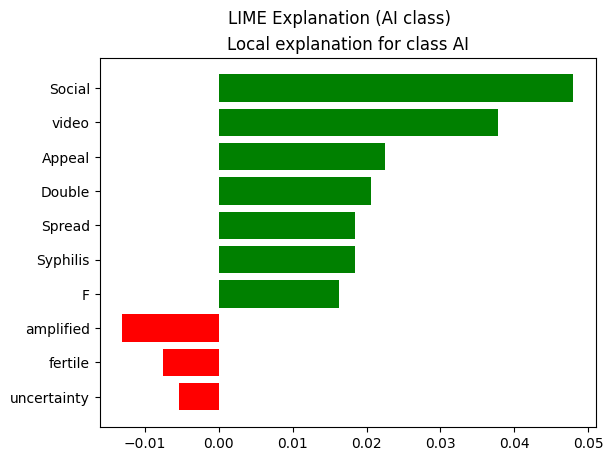

In [19]:
def get_user_text():
    """
    In a Colab environment, you might just define user_text in a cell,
    but here's a simple console approach:
    """
    print("Enter or paste your text (then press Enter):")
    user_input_text = input()
    return user_input_text


if __name__ == "__main__":
    # ----------------------------------------------------------------
    # 1) Basic config
    # ----------------------------------------------------------------
    absolute_path = "/content/drive/My Drive/Model"  # or a different path in Colab
    default_configs = {
        'base_model': 'facebook/opt-1.3b',
        'classifier': 'CustomOPTClassifier',
        'models_path': os.path.join(absolute_path, "models"),
        'model_name': '202409230028_subtaskA_monolingual_facebook_opt-1.3b',  # Example
    }
    app_configs.update(default_configs)

    # ----------------------------------------------------------------
    # 2) Select Device
    # ----------------------------------------------------------------
    device = target_device()

    # ----------------------------------------------------------------
    # 3) Load tokenizer & base model
    # ----------------------------------------------------------------
    tokenizer, base_model = get_pretrained_model()
    model = CustomOPTClassifier(base_model).to(device)

    # ----------------------------------------------------------------
    # 4) (Optional) Load checkpoint if present
    # ----------------------------------------------------------------
    model_path = os.path.join(
        app_configs['models_path'],
        app_configs['model_name'] + ".pt"
    )
    if os.path.isfile(model_path):
        model.load_state_dict(torch.load(model_path, map_location="cpu"))
        print(f"Model loaded from: {model_path}")
    else:
        print(f"[WARNING] No checkpoint found at: {model_path}. Classification may be random.")

    # ----------------------------------------------------------------
    # 5) Get user text
    # ----------------------------------------------------------------
    user_text = get_user_text().strip()
    if not user_text:
        print("No text entered! Exiting.")
        exit()

    # ----------------------------------------------------------------
    # 6) Build dynamic stopwords from the user's text itself
    #    Usually you'd have multiple texts, but here's a simple approach.
    # ----------------------------------------------------------------
    all_texts = [user_text]  # just the single user prompt
    my_dynamic_stopwords = build_dynamic_stopwords(all_texts, top_n=5)
    print("\nDynamic stopwords discovered from your text:\n", my_dynamic_stopwords)

    # ----------------------------------------------------------------
    # 7) Classify & Explain with SHAP & LIME
    # ----------------------------------------------------------------
    classify_and_explain(user_text, model, tokenizer, device, my_dynamic_stopwords)